In [ ]:
# if you want to run this notebook on cpu only
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
#import numpy as np
from PIL import Image
from math import floor
import numpy as np
import time
from functools import partial
from random import random
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
#Config Stuff
im_size = 64
latent_size = 128
BATCH_SIZE = 4
directory = "Faces"
n_images = 32132
suff = 'jpg'

In [ ]:
from AdaIN import AdaInstanceNormalization

#Style Z
def noise(n):
    return np.random.normal(0.0, 1.0, size = [n, latent_size])

#Noise Sample
def noiseImage(n):
    return np.random.uniform(0.0, 1.0, size = [n, im_size, im_size, 1])

#Get random samples from an array
def get_rand(array, amount):
    
    idx = np.random.randint(0, array.shape[0], amount)
    return array[idx]

def normalize(arr):
    return (arr - np.mean(arr)) / (np.std(arr) + 1e-7)

def fixed_generator(gen):
    for batch in gen:
        yield(batch, None)

In [ ]:
#This is the REAL data generator, which can take images from disk and temporarily use them in your program.
#Probably could/should get optimized at some point
class dataGenerator(object):
    
    def __init__(self, loc, n, flip = True, suffix = 'png'):
        self.loc = "data/"+loc
        datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)
        
        image_data_generator_big = datagen.flow_from_directory("./data/",
        target_size=(64,64), batch_size=BATCH_SIZE,
        class_mode=None, color_mode="rgb")
        
        self.generator = image_data_generator_big
    
    def get_batch(self, amount):
        
        return next(self.generator)

        

#### Custom Loss and Layers

In [ ]:
#Imports for layers and models
from keras.layers import Conv2D, Dense, AveragePooling2D, LeakyReLU, Activation
from keras.layers import Reshape, UpSampling2D, Dropout, Flatten, Input, add, Cropping2D
from keras.models import model_from_json, Model
from keras.optimizers import Adam
import keras.backend as K



#r1/r2 gradient penalty
def gradient_penalty_loss(y_true, y_pred, averaged_samples, weight):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    
    # weight * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty * weight)

#Upsample, Convolution, AdaIN, Noise, Activation, Convolution, AdaIN, Noise, Activation
def g_block(inp, style, noise, fil, u = True):
    
    b = Dense(fil)(style)
    b = Reshape([1, 1, fil])(b)
    g = Dense(fil)(style)
    g = Reshape([1, 1, fil])(g)

    n = Conv2D(filters = fil, kernel_size = 1, padding = 'same', kernel_initializer = 'he_normal')(noise)
    
    if u:
        out = UpSampling2D(interpolation = 'bilinear')(inp)
        out = Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')(out)
    else:
        out = Activation('linear')(inp)
    
    out = AdaInstanceNormalization()([out, b, g])
    out = add([out, n])
    out = LeakyReLU(0.01)(out)
    
    b = Dense(fil)(style)
    b = Reshape([1, 1, fil])(b)
    g = Dense(fil)(style)
    g = Reshape([1, 1, fil])(g)

    n = Conv2D(filters = fil, kernel_size = 1, padding = 'same', kernel_initializer = 'he_normal')(noise)
    
    out = Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')(out)
    out = AdaInstanceNormalization()([out, b, g])
    out = add([out, n])
    out = LeakyReLU(0.01)(out)
    
    return out

#Convolution, Activation, Pooling, Convolution, Activation
def d_block(inp, fil, p = True):
    
    route2 = Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')(inp)
    route2 = LeakyReLU(0.01)(route2)
    if p:
        route2 = AveragePooling2D()(route2)
    route2 = Conv2D(filters = fil, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')(route2)
    out = LeakyReLU(0.01)(route2)
    
    return out

### Base GAN

In [ ]:
#This object holds the models
class GAN(object):
    
    def __init__(self, lr = 0.0001):
        
        #Models
        self.D = None
        self.G = None
        
        self.DM = None
        self.AM = None
        
        #Config
        self.LR = lr
        self.steps = 1
        
        #Init Models
        self.discriminator()
        self.generator()
        
    def discriminator(self):
        
        if self.D:
            return self.D
        
        inp = Input(shape = [im_size, im_size, 3])
        
        # Size
        x = d_block(inp, 16) #Size / 2
        x = d_block(x, 32) #Size / 4
        x = d_block(x, 64) #Size / 8
        
        if (im_size > 32):
            x = d_block(x, 128) #Size / 16
        
        if (im_size > 64):
            x = d_block(x, 192) #Size / 32
        
        if (im_size > 128):
            x = d_block(x, 256) #Size / 64
        
        if (im_size > 256):
            x = d_block(x, 384) #Size / 128
            
        if (im_size > 512):
            x = d_block(x, 512) #Size / 256
            
            
        x = Flatten()(x)
        
        x = Dense(128)(x)
        x = Activation('relu')(x)
        
        x = Dropout(0.6)(x)
        x = Dense(1)(x)
        
        self.D = Model(inputs = inp, outputs = x)
        
        return self.D
    
    def generator(self):
        
        if self.G:
            return self.G
        
        #Style FC, I only used 2 fully connected layers instead of 8 for faster training
        inp_s = Input(shape = [latent_size])
        sty = Dense(512, kernel_initializer = 'he_normal')(inp_s)
        sty = LeakyReLU(0.1)(sty)
        sty = Dense(512, kernel_initializer = 'he_normal')(sty)
        sty = LeakyReLU(0.1)(sty)
        
        #Get the noise image and crop for each size
        inp_n = Input(shape = [im_size, im_size, 1])
        noi = [Activation('linear')(inp_n)]
        curr_size = im_size
        while curr_size > 4:
            curr_size = int(curr_size / 2)
            noi.append(Cropping2D(int(curr_size/2))(noi[-1]))
        
        #Here do the actual generation stuff
        inp = Input(shape = [1])
        x = Dense(4 * 4 * 512, kernel_initializer = 'he_normal')(inp)
        x = Reshape([4, 4, 512])(x)
        x = g_block(x, sty, noi[-1], 512, u=False)
        
        if(im_size >= 1024):
            x = g_block(x, sty, noi[7], 512) # Size / 64
        if(im_size >= 512):
            x = g_block(x, sty, noi[6], 384) # Size / 64
        if(im_size >= 256):
            x = g_block(x, sty, noi[5], 256) # Size / 32
        if(im_size >= 128):
            x = g_block(x, sty, noi[4], 192) # Size / 16
        if(im_size >= 64):
            x = g_block(x, sty, noi[3], 128) # Size / 8
            
        x = g_block(x, sty, noi[2], 64) # Size / 4
        x = g_block(x, sty, noi[1], 32) # Size / 2
        x = g_block(x, sty, noi[0], 16) # Size
        
        x = Conv2D(filters = 3, kernel_size = 1, padding = 'same', activation = 'sigmoid')(x)
        
        self.G = Model(inputs = [inp_s, inp_n, inp], outputs = x)
        
        return self.G
    
    def AdModel(self):
        
        #D does not update
        self.D.trainable = False
        for layer in self.D.layers:
            layer.trainable = False
        
        #G does update
        self.G.trainable = True
        for layer in self.G.layers:
            layer.trainable = True
        
        #This model is simple sequential one with inputs and outputs
        gi = Input(shape = [latent_size])
        gi2 = Input(shape = [im_size, im_size, 1])
        gi3 = Input(shape = [1])
        
        gf = self.G([gi, gi2, gi3])
        df = self.D(gf)
        
        self.AM = Model(inputs = [gi, gi2, gi3], outputs = df)
            
        self.AM.compile(optimizer = Adam(self.LR, beta_1 = 0, beta_2 = 0.99, decay = 0.00001), loss = 'mse')
        
        return self.AM
    
    def DisModel(self):
        
        #D does update
        self.D.trainable = True
        for layer in self.D.layers:
            layer.trainable = True
        
        #G does not update
        self.G.trainable = False
        for layer in self.G.layers:
            layer.trainable = False
        
        # Real Pipeline
        ri = Input(shape = [im_size, im_size, 3])
        dr = self.D(ri)
        
        # Fake Pipeline
        gi = Input(shape = [latent_size])
        gi2 = Input(shape = [im_size, im_size, 1])
        gi3 = Input(shape = [1])
        gf = self.G([gi, gi2, gi3])
        df = self.D(gf)
        
        # Samples for gradient penalty
        # For r1 use real samples (ri)
        # For r2 use fake samples (gf)
        da = self.D(ri)
        
        # Model With Inputs and Outputs
        self.DM = Model(inputs=[ri, gi, gi2, gi3], outputs=[dr, df, da])
        
        # Create partial of gradient penalty loss
        # For r1, averaged_samples = ri
        # For r2, averaged_samples = gf
        # Weight of 10 typically works
        partial_gp_loss = partial(gradient_penalty_loss, averaged_samples = ri, weight = 5)
        
        #Compile With Corresponding Loss Functions
        self.DM.compile(optimizer=Adam(self.LR, beta_1 = 0, beta_2 = 0.99, decay = 0.00001), loss=['mse', 'mse', partial_gp_loss])
        
        return self.DM

### StyleGAN 

In [ ]:
class WGAN(object):
    
    def __init__(self, steps = -1, lr = 0.0001, silent = True):
        
        self.GAN = GAN(lr = lr)
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        self.generator = self.GAN.generator()
        
        if steps >= 0:
            self.GAN.steps = steps
        
        self.lastblip = time.clock()
        
        self.noise_level = 0
        
        
        #self.im = dataGenerator(directory, n_images, suffix = suff, flip = True)
        
        
        self.silent = silent

        #Train Generator to be in the middle, not all the way at real. Apparently works better??
        self.ones = np.ones((BATCH_SIZE, 1), dtype=np.float32)
        self.zeros = np.zeros((BATCH_SIZE, 1), dtype=np.float32)
        self.nones = -self.ones
        
        self.enoise = noise(8)
        self.enoiseImage = noiseImage(8)
    
    def train(self):
        
        #Train Alternating
        a = self.train_dis()
        b = self.train_gen()
        
        #Print info
        if self.GAN.steps % 20 == 0 and not self.silent:
            print("\n\nRound " + str(self.GAN.steps) + ":")
            print("D: " + str(a))
            print("G: " + str(b))
            s = round((time.clock() - self.lastblip) * 1000) / 1000
            print("T: " + str(s) + " sec")
            self.lastblip = time.clock()
            
            #Save Model
            if self.GAN.steps % 500 == 0:
                self.save(floor(self.GAN.steps / 10000))
            if self.GAN.steps % 1000 == 0:
                self.evaluate(floor(self.GAN.steps / 1000))
            
        
        self.GAN.steps = self.GAN.steps + 1
          
    def train_dis(self):
        
        #Get Data
        
        train_data = [self.im.get_batch(BATCH_SIZE), noise(BATCH_SIZE), noiseImage(BATCH_SIZE), self.ones]
        
        #Train
        d_loss = self.DisModel.train_on_batch(x=train_data, y=[self.ones, self.nones, self.ones])
        
        return d_loss
       
    def train_gen(self):
        
        #Train
        g_loss = self.AdModel.train_on_batch([noise(BATCH_SIZE), noiseImage(BATCH_SIZE), self.ones], self.zeros)
        
        return g_loss
    
    def evaluate(self, num = 0, trunc = 2.0): #8x4 images, bottom row is constant
        
        n = noise(32)
        n2 = noiseImage(32)
        
        im2 = self.generator.predict([n, n2, np.ones([32, 1])])
        im3 = self.generator.predict([self.enoise, self.enoiseImage, np.ones([8, 1])])
        
        r12 = np.concatenate(im2[:8], axis = 1)
        r22 = np.concatenate(im2[8:16], axis = 1)
        r32 = np.concatenate(im2[16:24], axis = 1)
        r43 = np.concatenate(im3[:8], axis = 1)
        
        c1 = np.concatenate([r12, r22, r32, r43], axis = 0)
        
        x = Image.fromarray(np.uint8(c1*255))
        
        x.save("./figs/"+str(num)+".jpg")
        
    def evaluate2(self, s1, s2, n1, n2, num = 0, weight = 0.5):
        
        s = normalize((s2 * weight) + (s1 * (1 - weight)))
        n = (n2 * weight) + (n1 * (1 - weight))
        
        im2 = self.generator.predict([s, n, np.ones([32, 1])])
        
        r12 = np.concatenate(im2[:8], axis = 1)
        r22 = np.concatenate(im2[8:16], axis = 1)
        r32 = np.concatenate(im2[16:24], axis = 1)
        r43 = np.concatenate(im2[24:], axis = 1)
        
        c1 = np.concatenate([r12, r22, r32, r43], axis = 0)
        
        x = Image.fromarray(np.uint8(c1*255))
        
        x.save("./figs/i"+str(num)+".jpg")
        
    def evalTrunc(self, num = 0, trunc = 1.8):
        
        n = np.clip(noise(16), -trunc, trunc)
        n2 = noiseImage(16)
        
        im2 = self.generator.predict([n, n2, np.ones([16, 1])])
        
        r12 = np.concatenate(im2[:4], axis = 1)
        r22 = np.concatenate(im2[4:8], axis = 1)
        r32 = np.concatenate(im2[8:12], axis = 1)
        r43 = np.concatenate(im2[12:], axis = 1)
        
        c1 = np.concatenate([r12, r22, r32, r43], axis = 0)
        
        x = Image.fromarray(np.uint8(c1*255))
        
        x.save("/figs/t"+str(num)+".jpg")
        
    
    def saveModel(self, model, name, num): #Save a Model
        json = model.to_json()
        with open("./models/"+name+".json", "w") as json_file:
            json_file.write(json)
            
        model.save_weights("./models/"+name+"_"+str(num)+".h5")
        
    def loadModel(self, name, num): #Load a Model
        
        file = open("./models/"+name+".json", 'r')
        json = file.read()
        file.close()
        
        mod = model_from_json(json, custom_objects = {'AdaInstanceNormalization': AdaInstanceNormalization})
        
        mod.load_weights("./models/"+name+"_"+str(num)+".h5")
        
        return mod
    
    def save(self, num): #Save JSON and Weights into /Models/
        self.saveModel(self.GAN.G, "gen", num)
        self.saveModel(self.GAN.D, "dis", num)
        

    def load(self, num): #Load JSON and Weights from /Models/
        steps1 = self.GAN.steps
        
        self.GAN = None
        self.GAN = GAN()
        
        #Load Models
        self.GAN.G = self.loadModel("gen", num)
        self.GAN.D = self.loadModel("dis", num)
        
        self.GAN.steps = steps1
        
        self.generator = self.GAN.generator()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel() 
    
    def interpolation(self, latent_a, latent_b, n=5):
        weights = np.linspace(0.0,1.0, num=10)
        images = []

        for weight in weights:
            temp = model.generator.predict([componenta1*(1-weight) + componenta2*weight, noiseImage(1), np.ones([1, 1])])
            temp = np.uint8(temp.reshape(im_size,im_size,3)*255)
            images.append(temp)
        return np.concatenate(images, axis=1)

In [ ]:
model = WGAN(lr = 0.0003, silent=False)
model.load(61)

In [ ]:
model.evaluate()

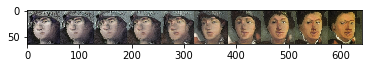

In [110]:
plt.imshow(model.interpolation(componenta1, componenta2, 3))